In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/abalint/projects/phd/Annex82/enfobench-models'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

## Load target values

In [44]:
data = pd.read_csv("./data/load.csv", parse_dates=['timestamp'], index_col="timestamp")

In [45]:
data.head()

,value
timestamp,
2012-09-24 12:30:00,1836.0
2012-09-24 13:00:00,1946.0
2012-09-24 13:30:00,1030.0
2012-09-24 14:00:00,562.0
2012-09-24 14:30:00,560.0


In [46]:
data.tail()

,value
timestamp,
2014-02-14 21:30:00,880.0
2014-02-14 22:00:00,914.0
2014-02-14 22:30:00,830.0
2014-02-14 23:00:00,1884.0
2014-02-14 23:30:00,1578.0


<Axes: xlabel='timestamp'>

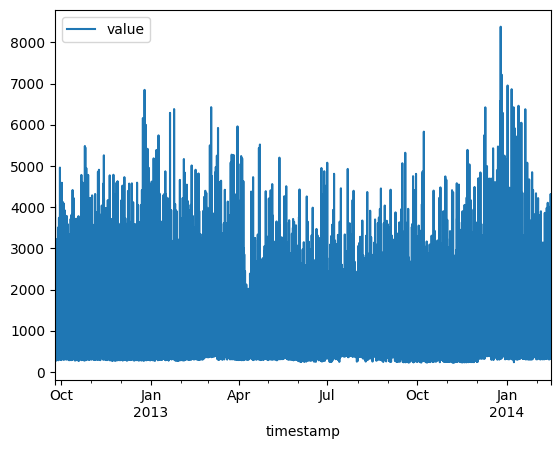

In [47]:
data.plot()

## Load covariates

In [48]:
covariates = pd.read_csv("./data/covariates.csv", parse_dates=['timestamp'], index_col='timestamp')

In [49]:
covariates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21165 entries, 2011-11-11 00:00:00 to 2014-02-15 23:00:00
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   visibility           21165 non-null  float64
 1   windBearing          21165 non-null  int64  
 2   temperature          21165 non-null  float64
 3   dewPoint             21165 non-null  float64
 4   pressure             21152 non-null  float64
 5   apparentTemperature  21165 non-null  float64
 6   windSpeed            21165 non-null  float64
 7   precipType           21165 non-null  object 
 8   icon                 21165 non-null  object 
 9   humidity             21165 non-null  float64
 10  summary              21165 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 1.9+ MB


In [50]:
covariates.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
timestamp,,,,,,,,,,,
2011-11-11 00:00:00,5.97,104,10.24,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
2011-11-11 01:00:00,4.88,99,9.76,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2011-11-11 02:00:00,3.70,98,9.46,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
2011-11-11 03:00:00,3.12,99,9.23,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
2011-11-11 04:00:00,1.85,111,9.26,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


In [51]:
covariates.tail()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
timestamp,,,,,,,,,,,
2014-02-15 19:00:00,12.68,247,7.39,3.06,997.07,3.91,6.08,rain,partly-cloudy-night,0.74,Partly Cloudy
2014-02-15 20:00:00,13.78,249,6.56,2.76,998.15,3.03,5.61,rain,clear-night,0.77,Clear
2014-02-15 21:00:00,14.31,248,6.47,2.71,999.28,3.06,5.25,rain,clear-night,0.77,Clear
2014-02-15 22:00:00,14.31,248,5.96,2.69,1000.33,2.68,4.69,rain,clear-night,0.80,Clear
2014-02-15 23:00:00,14.31,246,5.38,2.60,1001.25,1.77,5.09,rain,clear-night,0.82,Clear


# Create a Multivariate Dataset

In [52]:
from enfobench.evaluation import Dataset

### Note:
- these datasets are cleaned and contain no missing values
- the target has a resolution of 30 minutes but the weather data has observations only every hour

In [53]:
multivariate_dataset = Dataset(
    target=data.value,  # as a pd.Series
    covariates=covariates,  # as a pd.DataFrame
)

# Create Model

In [54]:
from enfobench.evaluation import ModelInfo, ForecasterType
from enfobench.evaluation.utils import create_forecast_index

class ExampleModel:
    
    def __init__(self, param1: int):
        self.param1 = param1

    def info(self):
        return ModelInfo(
            name="TestModel",
            type=ForecasterType.point,
            params={
                "param1": 1,
            },
        )

    def forecast(
        self,
        horizon: int,
        history: pd.DataFrame,
        past_covariates=None,
        future_covariates=None,
        level=None,
        **kwargs,
    ):
        index = create_forecast_index(history, horizon)
        prediction = pd.DataFrame(
            data={
                "ds": index,
                "yhat": np.full(horizon, fill_value=history["y"].mean()) + self.param1,
            }
        )
        return prediction

# Perform crossvalidation on your model locally

In [55]:
from enfobench.evaluation import cross_validate

In [56]:
model = ExampleModel(1)

In [57]:
crossval_df = cross_validate(
    model, 
    multivariate_dataset,
    start_date=pd.Timestamp("2013-07-01T10:00:00"),
    end_date=pd.Timestamp("2013-08-01T00:00:00"),
    horizon=pd.Timedelta("38 hours"), 
    step=pd.Timedelta("1 day"), 
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 257.56it/s]


In [58]:
crossval_df.head()

,ds,yhat,cutoff_date
0,2013-07-01 10:30:00,1106.235189,2013-07-01 10:00:00
1,2013-07-01 11:00:00,1106.235189,2013-07-01 10:00:00
2,2013-07-01 11:30:00,1106.235189,2013-07-01 10:00:00
3,2013-07-01 12:00:00,1106.235189,2013-07-01 10:00:00
4,2013-07-01 12:30:00,1106.235189,2013-07-01 10:00:00


# Evaluate metrics

In [59]:
from enfobench.evaluation import evaluate_metrics_on_forecasts
from enfobench.evaluation.metrics import mean_absolute_error, mean_bias_error

In [60]:
# Merge the target values with your predictions
forecasts = crossval_df.merge(multivariate_dataset.target, on="ds", how="left")

In [61]:
forecasts.head()

,ds,yhat,cutoff_date,y
0,2013-07-01 10:30:00,1106.235189,2013-07-01 10:00:00,590.0
1,2013-07-01 11:00:00,1106.235189,2013-07-01 10:00:00,618.0
2,2013-07-01 11:30:00,1106.235189,2013-07-01 10:00:00,704.0
3,2013-07-01 12:00:00,1106.235189,2013-07-01 10:00:00,698.0
4,2013-07-01 12:30:00,1106.235189,2013-07-01 10:00:00,644.0


In [62]:
metrics = evaluate_metrics_on_forecasts(
    forecasts,
    metrics={
        "MAE": mean_absolute_error,
        "MBE": mean_bias_error
    }
)

<Axes: >

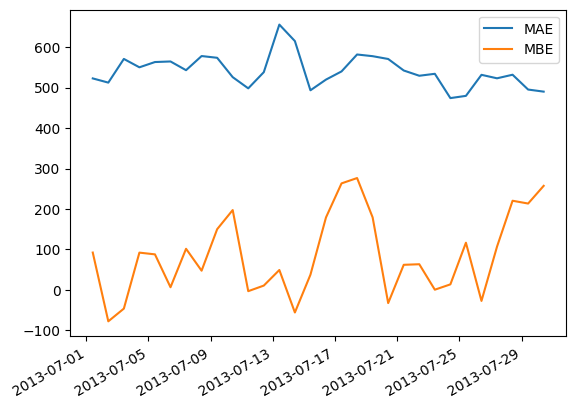

In [63]:
metrics.plot()

# Create external perfect forecast dataset to use as future covariates

In [64]:
from enfobench.evaluation.utils import create_perfect_forecasts_from_covariates
perfect_forecasts = create_perfect_forecasts_from_covariates(
    covariates,
    horizon=pd.Timedelta("7 days"),
    step=pd.Timedelta("12 hour"),
)

In [65]:
perfect_forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275828 entries, 0 to 275827
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ds                   275828 non-null  datetime64[ns]
 1   cutoff_date          275828 non-null  datetime64[ns]
 2   visibility           275828 non-null  float64       
 3   windBearing          275828 non-null  int64         
 4   temperature          275828 non-null  float64       
 5   dewPoint             275828 non-null  float64       
 6   pressure             275674 non-null  float64       
 7   apparentTemperature  275828 non-null  float64       
 8   windSpeed            275828 non-null  float64       
 9   precipType           275828 non-null  object        
 10  icon                 275828 non-null  object        
 11  humidity             275828 non-null  float64       
 12  summary              275828 non-null  object        
dtypes: datetime64[

In [66]:
perfect_forecasts.head()

,ds,cutoff_date,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,2011-11-11 01:00:00,2011-11-11,4.88,99,9.76,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
1,2011-11-11 02:00:00,2011-11-11,3.70,98,9.46,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
2,2011-11-11 03:00:00,2011-11-11,3.12,99,9.23,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
3,2011-11-11 04:00:00,2011-11-11,1.85,111,9.26,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy
4,2011-11-11 05:00:00,2011-11-11,1.96,115,9.33,8.87,1015.91,7.19,3.97,rain,fog,0.97,Foggy


In [67]:
perfect_forecasts.tail()

,ds,cutoff_date,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
275823,2014-02-15 08:00:00,2014-02-08 12:00:00,12.38,227,8.63,2.36,985.19,4.02,11.73,rain,wind,0.65,Windy and Mostly Cloudy
275824,2014-02-15 09:00:00,2014-02-08 12:00:00,12.13,231,8.55,2.42,986.47,3.90,11.86,rain,wind,0.65,Windy and Mostly Cloudy
275825,2014-02-15 10:00:00,2014-02-08 12:00:00,12.13,230,9.44,3.17,987.14,5.12,11.79,rain,wind,0.65,Windy and Mostly Cloudy
275826,2014-02-15 11:00:00,2014-02-08 12:00:00,12.13,235,9.38,3.54,987.89,5.12,11.27,rain,wind,0.67,Windy and Mostly Cloudy
275827,2014-02-15 12:00:00,2014-02-08 12:00:00,12.13,234,9.90,3.15,988.56,5.79,11.43,rain,wind,0.63,Windy and Mostly Cloudy


In [68]:
data.tail()

,value
timestamp,
2014-02-14 21:30:00,880.0
2014-02-14 22:00:00,914.0
2014-02-14 22:30:00,830.0
2014-02-14 23:00:00,1884.0
2014-02-14 23:30:00,1578.0


In [69]:
covariates.tail()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
timestamp,,,,,,,,,,,
2014-02-15 19:00:00,12.68,247,7.39,3.06,997.07,3.91,6.08,rain,partly-cloudy-night,0.74,Partly Cloudy
2014-02-15 20:00:00,13.78,249,6.56,2.76,998.15,3.03,5.61,rain,clear-night,0.77,Clear
2014-02-15 21:00:00,14.31,248,6.47,2.71,999.28,3.06,5.25,rain,clear-night,0.77,Clear
2014-02-15 22:00:00,14.31,248,5.96,2.69,1000.33,2.68,4.69,rain,clear-night,0.80,Clear
2014-02-15 23:00:00,14.31,246,5.38,2.60,1001.25,1.77,5.09,rain,clear-night,0.82,Clear


In [70]:
full_dataset = Dataset(
    target=data.value,
    covariates=covariates,
    external_forecasts=perfect_forecasts,
)

In [71]:
crossval_df = cross_validate(
    ExampleModel(200), 
    full_dataset,
    start_date=pd.Timestamp("2013-07-01T10:00:00"),
    end_date=pd.Timestamp("2013-08-01T00:00:00"),
    horizon=pd.Timedelta("38 hours"), 
    step=pd.Timedelta("1 day"), 
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.49it/s]


Merge the target values with the forecasts

In [72]:
forecasts = crossval_df.merge(multivariate_dataset.target, on='ds', how='left')

Evaluate the metrics you are interested in.

In [73]:
metrics = evaluate_metrics_on_forecasts(
    forecasts, 
    metrics={
        "MAE": mean_absolute_error,
        "MBE": mean_bias_error
    }
)

<Axes: >

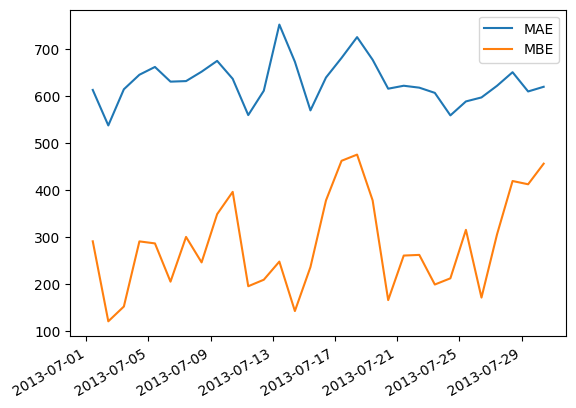

In [74]:
metrics.plot()